In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%reload_ext snakeviz

from collections import namedtuple
from functools import partial, wraps

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact
from mpl_toolkits.axes_grid1 import make_axes_locatable

from src.data_processing import (get_interpolated_position_dataframe,
                                 make_neuron_dataframe, make_tetrode_dataframe,
                                 make_tetrode_dataframe, reshape_to_segments,
                                 get_spike_indicator_dataframe)
from src.ripple_detection import get_epoch_ripples
from src.ripple_decoding import (combined_likelihood, poisson_likelihood, get_encoding_model,
                                 set_state_transition_matrix, predict_state,
                                 _compute_decision_state_probability,
                                 _get_bin_centers, get_state_transition_matrix,
                                 get_initial_conditions, _get_ripple_spikes)

In [2]:
Animal = namedtuple('Animal', {'directory', 'short_name'})
num_days = 8
days = range(1, num_days + 1)
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa')}

In [3]:
epoch_index = ('HPa', 8, 2)
print('\nDecoding ripples for Animal {0}, Day {1}, Epoch #{2}:'.format(
    *epoch_index))


Decoding ripples for Animal HPa, Day 8, Epoch #2:


In [4]:
n_place_bins = 61

In [5]:
# Include only CA1 neurons with spikes
neuron_info = make_neuron_dataframe(animals)[
    epoch_index].dropna()
tetrode_info = make_tetrode_dataframe(animals)[
    epoch_index]
neuron_info = pd.merge(tetrode_info, neuron_info,
                       on=['animal', 'day', 'epoch_ind',
                           'tetrode_number', 'area'],
                       how='right', right_index=True).set_index(
    neuron_info.index)
neuron_info = neuron_info[
    neuron_info.area.isin(['CA1', 'iCA1']) &
    (neuron_info.numspikes > 0) &
    ~neuron_info.descrip.str.endswith('Ref').fillna(False)]
print(neuron_info.loc[:, ['area', 'numspikes']])

# Train on when the rat is moving
position_info = get_interpolated_position_dataframe(
    epoch_index, animals)
spikes_data = [get_spike_indicator_dataframe(neuron_index, animals)
               for neuron_index in neuron_info.index]

# Make sure there are spikes in the training data times. Otherwise
# exclude that neuron
spikes_data = [spikes_datum for spikes_datum in spikes_data
               if spikes_datum[
                   position_info.speed > 4].sum().values > 0]

train_position_info = position_info.query('speed > 4')
train_spikes_data = [spikes_datum[position_info.speed > 4]
                     for spikes_datum in spikes_data]
place_bin_edges = np.linspace(
    np.floor(position_info.linear_distance.min()),
    np.ceil(position_info.linear_distance.max()),
    n_place_bins + 1)
place_bin_centers = _get_bin_centers(
    place_bin_edges)

                                                   area numspikes
animal day epoch_ind tetrode_number neuron_number                
HPa    8   2         1              2               CA1       872
                                    3               CA1      1075
                                    4               CA1       628
                                    5               CA1      2956
                                    6               CA1       893
                                    7               CA1       187
                     4              1               CA1      1504
                                    2               CA1      1430
                                    3               CA1       935
                                    4               CA1       280
                                    5               CA1       245
                                    6               CA1       436
                                    7               CA1       159
          

## Fit encoding model

In [6]:
conditional_intensity = get_encoding_model(
    train_position_info, train_spikes_data,
    place_bin_centers)

combined_likelihood_kwargs = dict(
    likelihood_function=poisson_likelihood,
    likelihood_kwargs=dict(
        conditional_intensity=conditional_intensity)
)

		...Neuron #1
		...Neuron #2
		...Neuron #3
		...Neuron #4
		...Neuron #5
		...Neuron #6
		...Neuron #7
		...Neuron #8
		...Neuron #9
		...Neuron #10
		...Neuron #11
		...Neuron #12
		...Neuron #13
		...Neuron #14
		...Neuron #15
		...Neuron #16
		...Neuron #17
		...Neuron #18
		...Neuron #19
		...Neuron #20
		...Neuron #21


## Fit state transition model

In [7]:
state_transition = get_state_transition_matrix(
    train_position_info, place_bin_edges)

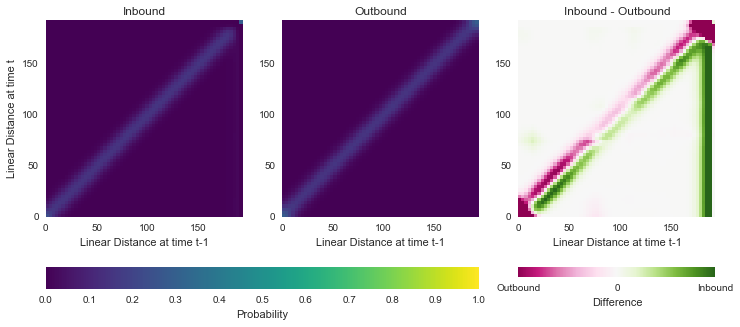

In [8]:
def plot_state_transition(state_transition, grid, ax=None,
                          vmin=0, vmax=1, cmap='viridis'):
    if ax is None:
        ax = plt.gca()
    x_grid, y_grid = np.meshgrid(grid, grid)
    mesh = ax.pcolormesh(x_grid, y_grid, state_transition,
                         cmap=cmap, vmin=vmin, vmax=vmax)
    grid_extent = (grid.min(), grid.max())
    ax.set_xlim(grid_extent)
    ax.set_ylim(grid_extent)
    ax.set_aspect('equal')
    return mesh
    
fig, ax = plt.subplots(1, 3, figsize=(12,6))

outbound_state_transitions = state_transition[:n_place_bins, :n_place_bins]
inbound_state_transitions = state_transition[n_place_bins+1:2*(n_place_bins)+1,
                                             n_place_bins+1:2*(n_place_bins)+1]


plot_state_transition(inbound_state_transitions, place_bin_edges, ax=ax[0])
ax[0].set_xlabel('Linear Distance at time t-1')
ax[0].set_ylabel('Linear Distance at time t')
ax[0].set_title('Inbound')

mesh1 = plot_state_transition(outbound_state_transitions, place_bin_edges, ax=ax[1])
ax[1].set_title('Outbound')
ax[1].set_xlabel('Linear Distance at time t-1')

state_transition_difference = inbound_state_transitions - outbound_state_transitions
mesh2 = plot_state_transition(state_transition_difference, place_bin_edges, ax=ax[2],
                              vmin=-0.01, vmax=0.01, cmap='PiYG')
ax[2].set_title('Inbound - Outbound')
ax[2].set_xlabel('Linear Distance at time t-1')

fig.colorbar(mesh1, ax=ax.ravel().tolist()[:2], label='Probability', orientation='horizontal')
cbar = fig.colorbar(mesh2, ax=ax[2], label='Difference', orientation='horizontal', ticks=[-0.01, 0, 0.01])
cbar.ax.set_xticklabels(['Outbound', '0', 'Inbound']);

## Initial Conditions

In [9]:
state_names = ['outbound_forward', 'outbound_reverse',
               'inbound_forward', 'inbound_reverse']
n_states = len(state_names)
initial_conditions = set_initial_conditions(
    place_bin_edges, place_bin_centers, n_states)

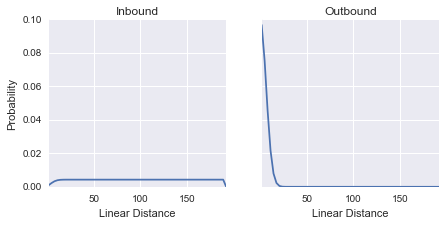

In [10]:
outbound_initial_conditions = initial_conditions[:n_place_bins]
inbound_initial_conditions = initial_conditions[n_place_bins+1:2*(n_place_bins)+1]

fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)
ax[0].plot(place_bin_centers, inbound_initial_conditions)
ax[0].set_ylabel('Probability')
ax[0].set_xlabel('Linear Distance')
ax[0].set_title('Inbound')
ax[0].set_xlim((place_bin_centers.min(), place_bin_centers.max()))

ax[1].plot(place_bin_centers, outbound_initial_conditions)
ax[1].set_xlabel('Linear Distance')
ax[1].set_title('Outbound')
ax[1].set_xlim((place_bin_centers.min(), place_bin_centers.max()));

## Decode

In [11]:
decoder_params = dict(
    initial_conditions=initial_conditions,
    state_transition=state_transition,
    likelihood_function=combined_likelihood,
    likelihood_kwargs=combined_likelihood_kwargs
)

In [12]:
sampling_frequency = 1500
ripple_times = get_epoch_ripples(
    epoch_index, animals, sampling_frequency=sampling_frequency)
test_spikes = _get_ripple_spikes(
    spikes_data, ripple_times, sampling_frequency)


Detecting ripples for Animal HPa, Day 8, Epoch #2...



In [13]:
%%snakeviz
posterior_density = [predict_state(ripple_spikes, **decoder_params)
                     for ripple_spikes in tqdm(test_spikes)]


 
*** Profile stats marshalled to file '/var/folders/rt/nhwr2l2937n0f8g854zq3s6w0000gn/T/tmp74g_51rx'. 


In [14]:
n_states = len(state_names)
n_ripples = len(ripple_times)
decision_state_probability = [
    _compute_decision_state_probability(density, n_states)
    for density in posterior_density]

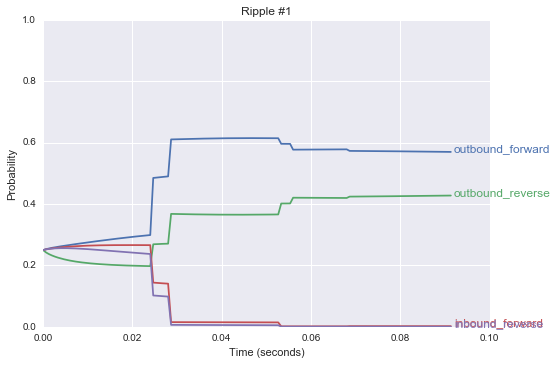

In [16]:
def browse_ripple_fits(decision_state_probability, state_names, sampling_frequency=1500):
    def plot_fits(ripple_ind):
        time_length = decision_state_probability[ripple_ind].shape[0]
        time = np.arange(time_length) / sampling_frequency
        lineObjects = plt.plot(time, decision_state_probability[ripple_ind])
        # plt.legend(lineObjects, discrete_state_names)
        for state_ind, state_name in enumerate(state_names):
                plt.text(time[-1] + (1 / sampling_frequency),
                         decision_state_probability[ripple_ind][-1, state_ind],
                         state_name,
                         color=lineObjects[state_ind].get_color())
        plt.ylim((0, 1))
        plt.xlabel('Time (seconds)')
        plt.ylabel('Probability')
        plt.title('Ripple #{ripple_number}'.format(ripple_number=ripple_ind+1))
    interact(plot_fits, ripple_ind=(0, len(decision_state_probability)-1), continuous_update=False)
        
browse_ripple_fits(decision_state_probability, state_names)

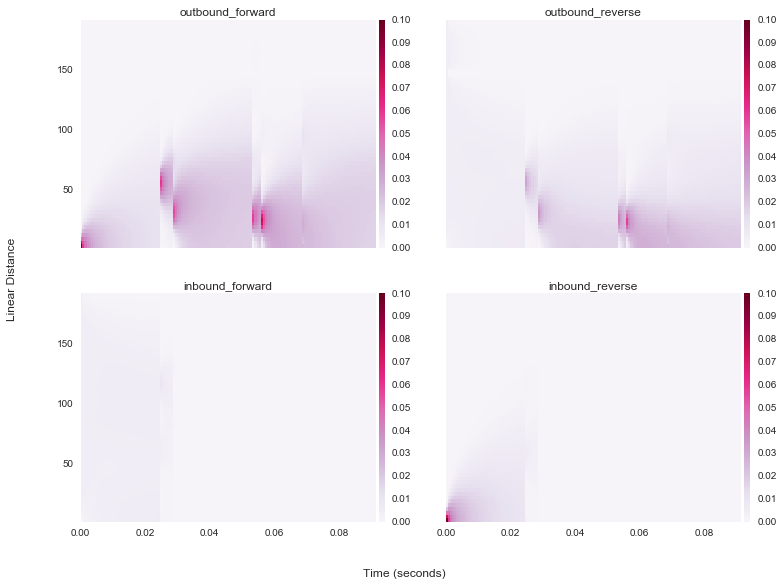

In [20]:
def browse_ripple_densities(posterior_density, state_names,
                            place_bin_centers,
                            sampling_frequency=1500):    
    def plot_fits(ripple_ind):
        fig, axes = plt.subplots(2, 2, figsize=(12,9), sharex=True, sharey=True)
        time_length = decision_state_probability[ripple_ind].shape[0]
        time = np.arange(time_length) / sampling_frequency
        n_time = posterior_density[ripple_ind].shape[0]
        n_states = len(state_names)
        new_shape = (n_time, n_states, -1)
        cur_density = np.reshape(posterior_density[ripple_ind], new_shape)
        [time_grid, place_bins] = np.meshgrid(time, place_bin_centers)
        for state_ind, ax in enumerate(axes.flatten()):
            try:
                mesh = ax.pcolormesh(time_grid, place_bins, cur_density[:, state_ind, :].squeeze().T,
                                     cmap='PuRd', vmin=0, vmax=.1)
                ax.set_xlim((time.min(), time.max()))
                ax.set_ylim((place_bin_centers.min(), place_bin_centers.max()))
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="2%", pad=0.05)
                plt.colorbar(mesh, cax=cax)
                ax.set_title(state_names[state_ind])
            except ValueError:
                pass
        fig.text(0.5, 0.04, 'Time (seconds)', ha='center')
        fig.text(0.04, 0.5, 'Linear Distance', va='center', rotation='vertical')
        
    interact(plot_fits, ripple_ind=(0, len(decision_state_probability)-1), continuous_update=False)
        
browse_ripple_densities(posterior_density, state_names,
                        place_bin_centers)